# Multicollinearity Issue: Jose Caloca

For explaining the multicollinearity issue in graphical and intuitive way, we are going to use venn diagrams. 

First we will do an example based on the basic linear model with 1 explanatory variable, and then this basic model will be compared graphically when another correlated variable is added.  

For this, we are interested in generating simulated correlated data 

# Basic Linear Regression Model: a graphical example

The earliest example I found is [Cohen and Cohen (1975)](https://www.taylorfrancis.com/books/mono/10.4324/9780203774441/applied-multiple-regression-correlation-analysis-behavioral-sciences-jacob-cohen-patricia-cohen-stephen-west-leona-aiken), who proposed visualizing the shared variance between 2–3 variables using Venn diagrams.

[ Hunt (1986)](https://link.springer.com/article/10.3758%2FBF03204399) however does the same but in a fancier way with some geometric equations to make them accurate.

Lastly, [ Ip (2001)](https://doi.org/10.1080/10691898.2001.11910646) shows a bunch of different examples and highlights some of the limitations of using this approach

## Data Simulation

For this example we simulate correlated data in form of continuos variables using the Cholesky decomposition method. This method reduces a symmetric matrix into a lower-triangular matrix which when multiplied by it’s transpose produces the original symmetric matrix

![cholesky](https://miro.medium.com/max/396/1*csrwPGJ1B9IpDaGM9BNong.png)

First of all we import all the libraries so that we can work on the examples presented.

In [29]:
# Import libraries
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

In the above picture we can see an example of the Cholesky matrix descomposition that using python, looks as follows:

In [2]:
# define a 3x3 matrix
A = np.array([[36, 30, 18], 
              [30, 41, 23], 
              [18, 23, 14]])

print("Intial Matrix (A)")
print(A)
print("------------------")
print("Cholesky decomposition takes the form: A = L x L*")

# Cholesky decomposition
L = np.linalg.cholesky(A)
print("lower triangular matrix L:")
print(L)
print("------------------")
print("Conjugate transpose of L (AKA L*):")
print(L.T)
# reconstruct
B = L.dot(L.T)
print("------------------")
print("Multiplication of L x L* that produces matrix A")
print(B)

Intial Matrix (A)
[[36 30 18]
 [30 41 23]
 [18 23 14]]
------------------
Cholesky decomposition takes the form: A = L x L*
lower triangular matrix L:
[[6. 0. 0.]
 [5. 4. 0.]
 [3. 2. 1.]]
------------------
Conjugate transpose of L (AKA L*):
[[6. 5. 3.]
 [0. 4. 2.]
 [0. 0. 1.]]
------------------
Multiplication of L x L* that produces matrix A
[[36. 30. 18.]
 [30. 41. 23.]
 [18. 23. 14.]]


Now we simulate our data for our example. For this, we find the Cholesky decomposition of the covariance matrix which in this case, the values of the covariance matrix are the same of the desired correlation matrix. Once calculated, we multiply the Cholesky decomposition by the matrix of uncorrelated random variables to create correlated variables

In [2]:
# set seed
np.random.seed(123)

# simulate correlated data using the Cholesky matrix decomposition

num_samples = 10000

# Desired number of variables 
num_variables = 3

# The desired mean values of the sample.
mu = np.array([10, 9, 9])

# The desired correlation matrix.
r = np.array([[1, .8, .5],
               [.8, 1, .3],
               [.5, .3, 1]])

print("Desired correlation matrix:")
print(pd.DataFrame(r))

# We find the Cholesky decomposition of the covariance matrix, and multiply that by the matrix of uncorrelated random variables to create correlated variables..

linalg = np.linalg
L = linalg.cholesky(r)

uncorrelated = np.random.standard_normal((num_variables, num_samples))

correlated = np.dot(L, uncorrelated) + np.array(mu).reshape(3, 1)

# We create a dataframe with correlated data.

data = pd.DataFrame(correlated).T

data.columns = ['Y', 'X1', 'X2']

# We check the correlation matrix of the dataframe which is very similar to the desired one above.

print("Final correlation matrix from simulated data")
data.corr().round(2) 

Desired correlation matrix:
     0    1    2
0  1.0  0.8  0.5
1  0.8  1.0  0.3
2  0.5  0.3  1.0
Final correlation matrix from simulated data


,Y,X1,X2
Y,1.0,0.80,0.50
X1,0.8,1.00,0.28
X2,0.5,0.28,1.00


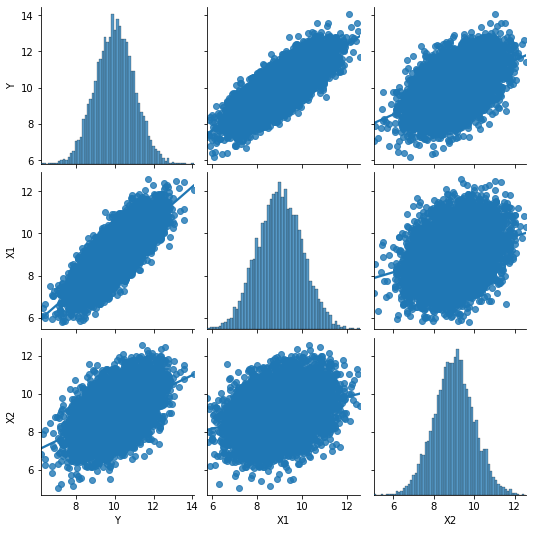

In [4]:
sns.pairplot(data, kind="reg")

Now we have the following dataset with correlated variables:

In [5]:
data.head(10)

,Y,X1,X2
0,8.914369,7.386914,9.540699
1,10.997345,9.610108,10.682766
2,10.282978,8.717015,9.364432
3,8.493705,9.221736,8.630311
4,9.421400,8.931620,6.894046
5,11.651437,10.449001,9.220025
6,7.573321,6.764074,9.133948
7,9.571087,8.007964,8.831282
8,11.265936,10.015630,9.936395
9,9.133260,8.090130,8.821305


In [6]:
data.describe()

,Y,X1,X2
count,10000.000000,10000.000000,10000.000000
mean,10.009712,9.013995,9.002930
std,0.998164,1.002388,0.996124
min,6.198622,5.793856,5.041916
25%,9.330154,8.330309,8.347290
50%,10.011846,9.008629,9.009639
75%,10.686122,9.703213,9.652050
max,14.068097,12.571978,12.575859


In the following regression diagrams, each variable is shown as a circle sized according to its variance, or:

$$\operatorname{var} = \sigma^2 = \frac{\sum (\color{gray}{\overbrace{\color{black}{x_i}}^{\substack{\text{Single} \ \text{value}}}} - \color{gray}{\overbrace{\color{black}{\bar{x}}}^{\substack{\text{Mean of} \ \text{all values}}}\color{black}{)^2}}}{\color{gray}{\underbrace{\color{black}{n}}_{\substack{\text{Sample} \ \text{size}}}}-1}$$

According to Ip (2001), you can also size the circles based on just the numerator of that equation, or the sum-of-squares:

$$\color{gray}{\overbrace{\color{black}{{\scriptstyle\sum} (x_i - \bar{x})^2}}^{\text{Sum of squares}}}$$

For this we create the following function that calculates the sum of squares:

In [3]:
def sum_squares(x):
    ss = sum((x - np.mean(x))**2)
    return ss
    print(ss)

## Relationship between 2 variables (Simple Regression Example)

Now we look at the relationship between Y and X1. We’ll use the sum of squares to calculate the size for each circle

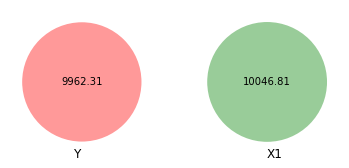

In [4]:
sum_squares_y = round(sum_squares(data.Y), 2)
sum_squares_x1 = round(sum_squares(data.X1), 2)

venn2(subsets=(sum_squares_y,sum_squares_x1,0), set_labels = ('Y', 'X1'))

Just looking at this plot, we can see that Y has less variation than X1.

These two variables are related to each other though and have some covariance. We can calculate the shared covariance using ANOVA. The nice thing about using the sum of squares values for these diagrams rather than variance values is that the function anova_lm from python reports its results as sums of squares, so we can use those results directly.

Let’s see how much of the variation between Y and X1 is shared:

In [5]:
model = ols('Y ~ X1', data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
X1,6374.423827,1.0,17762.94982,0.0
Residual,3587.888840,9998.0,NaN,NaN


If we look at the sum of squares row, we can see that 6374.42 sum of squares units (whatever those mean) are shared between the two variables, with 3587.88 not shared (or residual). 

For visualising the shared space (variation) between both variables we need to subtract the shared space from both Y and X1 as follows:

In [11]:
v.get_label_by_id.

<bound method VennDiagram.get_label_by_id of <matplotlib_venn._common.VennDiagram object at 0x000001AED79B0250>>

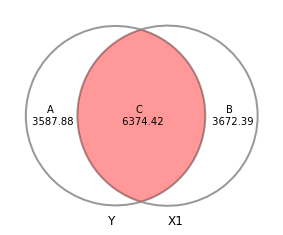

In [29]:
# Now we can visualize the covariance between these two variables.

sum_squares_both_y_x1 = round(aov_table.sum_sq[0], 2)

y = round(sum_squares_y - sum_squares_both_y_x1, 2)
x1 = round(sum_squares_x1 - sum_squares_both_y_x1, 2)
y_x1 = round(sum_squares_both_y_x1, 2)

v = venn2(subsets=(y,x1,y_x1), set_labels = ('Y', 'X1', 'Y_X1'))

v.get_label_by_id('100').set_text('A \n 3587.88')
v.get_patch_by_id('100').set_facecolor('White')
v.get_patch_by_id('100').set_edgecolor('Black')
v.get_patch_by_id('100').set_linestyle('-')
v.get_patch_by_id('100').set_linewidth(2)

v.get_label_by_id('010').set_text('B \n 3672.39')
v.get_patch_by_id('010').set_facecolor('White')
v.get_patch_by_id('010').set_edgecolor('Black')
v.get_patch_by_id('010').set_linestyle('-')
v.get_patch_by_id('010').set_linewidth(2)

v.get_label_by_id('110').set_text('C \n 6374.42')
v.get_patch_by_id('110').set_facecolor('Red')



This venn diagram helps us to visualise the covariance between these two variables.

Area C here represents the amount of variation in Y explained by X1, while Area A represents the unexplained portion of Y. In regression language, A is basically the error term:

$$\hat{Y} = \beta_0 + \beta_1 X_1 + \color{gray}{\overbrace{\epsilon}^{\color{black}{\text{A}}}}$$

The great thing about visualizing this is that C also represents the $R^2$ In general, $R^2$ is the ratio between explained and total variance:

$$R^2 = \frac{\text{Explained variance in }Y}{\text{Total variance in }Y}$$

Based on this diagram, we can write this as:

$$R^2 = \frac{C}{A + C}$$

Using actual numbers, we get:

$$R^2 = \frac{6374.42}{3587.88 + 6374.42} = 0.639$$

According to this, X1 explains 64% of the variation in Y. That’s apparent visually—the overlapping space covers about 64% of the total Y circle.

We calculate this as follows:

In [30]:
# We can however calculate R2 from the areas presented
r_squared = y_x1 / (y + y_x1)
r_squared

0.6398536082494923

When running the regression model we check the information by extracting this value from the basic linear regression model used when running the ANOVA.

In [31]:
# We confirm the results of R2 as follows:
model.rsquared

0.6398538211050541

## Relationship between three variables

Now we look at the overlapping space between three different variables. It’s also a little more complicated, since we need to calculate a bunch of different shared variances and do some set theory calculations to find the exact size.

For example the following diagram which is exposed for illustration issues:

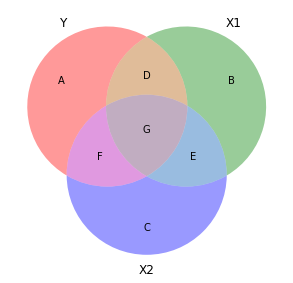

In [32]:
plt.figure(figsize=(5, 5))
v = venn3(subsets=(4,4,2,4,2,2,2), set_labels = ('Y', 'X1', 'X2'))

v.get_label_by_id('100').set_text('A')
v.get_label_by_id('010').set_text('B')
v.get_label_by_id('001').set_text('C')
v.get_label_by_id('110').set_text('D')
v.get_label_by_id('011').set_text('E')
v.get_label_by_id('101').set_text('F')
v.get_label_by_id('111').set_text('G')

Here the same principles apply. The entire circles for Y, X1, and X2 represent each variable’s total variance. Overlapping areas represent shared variance. For instance, the combination of D and G here (or $A \cap B$) is the covariance that we calculated previously

That means we can calculate $R^2$ like this:

$$R^2 = \frac{D + G + F}{A + D + G + F}$$

This visualization also helps with the intuition of $R^2$. Generally when you add additional variables to a regression model, the $R^2$ increases. That’s because you’re adding another circle to the diagram and absorbing more of the variation in the outcome.

For instance, even though the numbers in this diagram aren’t to scale at all, you can see that (D + G) (the $R^2$ that we calculated in the two-variable diagram) is smaller than (D + E + G). There’s more explained variance here.

The following table helps us to understand the meaning of each segment:

| Segment       | Explanation                                               |
|---------------|-----------------------------------------------------------|
| A + D + E + G | Total variation in Y                                      |
| B + D + F + G | Total variation in X1                                     |
| C + E + F + G | Total variation in X2                                     |
| A             | Unexplained variation in Y after accounting for X1 and X2 |
| B             | Unexplained variation in X1 after accounting for Y and X2 |
| C             | Unexplained variation in X2 after accounting for Y and X1 |
| D + G         | Variance shared by Y and X1                               |
| E + G         | Variance shared by Y and X2                               |
| D + G         | Variance shared by X1 and X2                              |
| D             | Variance only between Y and X1, without influence from X2 |
| E             | Variance only between Y and X2, without influence from X1 |
| F             | Variance only between X1 and X2, without influence from Y |
| G             | Variance shared by Y, X1,   and X2                        |

Now we calculate all the segments of the table:

In [33]:
#Calculation of areas: 

y_total = round(sum_squares(data.Y))    # A + D + F + G
x1_total = round(sum_squares(data.X1))  # B + D + E + G
x2_total = round(sum_squares(data.X2))  # C + E + F + G


# A

model = ols('Y ~ X2 + X1', data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
y_alone = round(aov_table.sum_sq[2], 2)

# B

model = ols('X1 ~ Y + X2', data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
x1_alone = round(aov_table.sum_sq[2], 2)

# C

model = ols('X2 ~ Y + X1', data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
x2_alone = round(aov_table.sum_sq[2], 2)

# D + G

model = ols('Y ~ X1', data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
y_plus_x1 = round(aov_table.sum_sq[0], 2)

# F + G

model = ols('Y ~ X2', data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
y_plus_x2 = round(aov_table.sum_sq[0], 2)

# E + G

model = ols('X1 ~ X2', data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
x1_plus_x2 = round(aov_table.sum_sq[0], 2)

# D = (A + D + F + G) − A − (F + G)

y_x1_alone = round(y_total - y_alone - y_plus_x2)

# E = (B + D + E + G) − B − (D + G)

y_x2_alone = round(y_total - y_alone - y_plus_x1)

# G = (D + G) − D

y_x1_x2_alone = round(y_plus_x1 - y_x1_alone)

# F = (F + G) - G

x1_x2_alone =  round(y_plus_x2 - y_x1_x2_alone, 2)

In [36]:
print("{}".format(x1_x2_alone))

789.57


Based on the calculated areas (segments) we can plot them in a diagram:

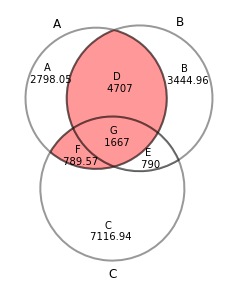

In [50]:
plt.figure(figsize=(5, 5))
v = venn3(subsets=(y_alone, x1_alone, y_x1_alone, x2_alone, y_x2_alone, x1_x2_alone, y_x1_x2_alone))


v.get_label_by_id('100').set_text('A \n {}'.format(y_alone))
v.get_patch_by_id('100').set_facecolor('White')
v.get_patch_by_id('100').set_edgecolor('Black')
v.get_patch_by_id('100').set_linestyle('-')
v.get_patch_by_id('100').set_linewidth(2)

v.get_label_by_id('010').set_text('B \n {}'.format(x1_alone))
v.get_patch_by_id('010').set_facecolor('White')
v.get_patch_by_id('010').set_edgecolor('Black')
v.get_patch_by_id('010').set_linestyle('-')
v.get_patch_by_id('010').set_linewidth(2)

v.get_label_by_id('001').set_text('C \n {}'.format(x2_alone))
v.get_patch_by_id('001').set_facecolor('White')
v.get_patch_by_id('001').set_edgecolor('Black')
v.get_patch_by_id('001').set_linestyle('-')
v.get_patch_by_id('001').set_linewidth(2)

v.get_label_by_id('110').set_text('D \n {}'.format(y_x1_alone))
v.get_patch_by_id('110').set_facecolor('Red')
v.get_patch_by_id('110').set_edgecolor('Black')
v.get_patch_by_id('110').set_linestyle('-')
v.get_patch_by_id('110').set_linewidth(2)

v.get_label_by_id('011').set_text('E \n {}'.format(y_x2_alone))
v.get_patch_by_id('011').set_facecolor('White')
v.get_patch_by_id('011').set_edgecolor('Black')
v.get_patch_by_id('011').set_linestyle('-')
v.get_patch_by_id('011').set_linewidth(2)

v.get_label_by_id('101').set_text('F \n {}'.format(x1_x2_alone))
v.get_patch_by_id('101').set_facecolor('Red')
v.get_patch_by_id('101').set_edgecolor('Black')
v.get_patch_by_id('101').set_linestyle('-')
v.get_patch_by_id('101').set_linewidth(2)

v.get_label_by_id('111').set_text('G \n {}'.format(y_x1_x2_alone))
v.get_patch_by_id('111').set_facecolor('Red')
v.get_patch_by_id('111').set_edgecolor('Black')
v.get_patch_by_id('111').set_linestyle('-')
v.get_patch_by_id('111').set_linewidth(2)

Once again we calculate the $R^2$ 

$$R^2 = \frac{D + G + F}{A + D + G + F} = \frac{4707 + 1667 + 789.5}{2798.05+4707 + 1667 + 789.5} = 0.72$$

In [16]:
# R2 = D + G + F / A + D + G + F
r_squared = (y_x1_alone + y_x1_x2_alone + x1_x2_alone)/(y_alone + y_x1_alone + y_x1_x2_alone + x1_x2_alone)

round(r_squared,2)

0.72

This information is confirmed with the regression model:

In [17]:
model = ols('Y ~ X1 + X2', data).fit()
round(model.rsquared,2)

0.72

## Multicollinearity Issue

Another neat feature of this kind of diagram is that it helps visualize multicollinearity, or the issues that arise when you control for explanatory variables that explain the same kind of variation in the outcome. Multicollinearity leads to strange coefficient estimates and variance inflation because mathematically the regression model has no way of telling which of the highly correlated explanatory variables explain which parts of the outcome.

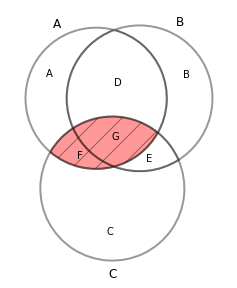

In [18]:
plt.figure(figsize=(5, 5))
v = venn3(subsets=(y_alone, x1_alone, y_x1_alone, x2_alone, y_x2_alone, x1_x2_alone, y_x1_x2_alone))

v.get_label_by_id('100').set_text('A')
v.get_patch_by_id('100').set_facecolor('White')
v.get_patch_by_id('100').set_edgecolor('Black')
v.get_patch_by_id('100').set_linestyle('-')
v.get_patch_by_id('100').set_linewidth(2)

v.get_label_by_id('010').set_text('B')
v.get_patch_by_id('010').set_facecolor('White')
v.get_patch_by_id('010').set_edgecolor('Black')
v.get_patch_by_id('010').set_linestyle('-')
v.get_patch_by_id('010').set_linewidth(2)

v.get_label_by_id('001').set_text('C')
v.get_patch_by_id('001').set_facecolor('White')
v.get_patch_by_id('001').set_edgecolor('Black')
v.get_patch_by_id('001').set_linestyle('-')
v.get_patch_by_id('001').set_linewidth(2)

v.get_label_by_id('110').set_text('D')
v.get_patch_by_id('110').set_facecolor('White')
v.get_patch_by_id('110').set_edgecolor('Black')
v.get_patch_by_id('110').set_linestyle('-')
v.get_patch_by_id('110').set_linewidth(2)

v.get_label_by_id('011').set_text('E')
v.get_patch_by_id('011').set_facecolor('White')
v.get_patch_by_id('011').set_edgecolor('Black')
v.get_patch_by_id('011').set_linestyle('-')
v.get_patch_by_id('011').set_linewidth(2)

v.get_label_by_id('101').set_text('F')
v.get_patch_by_id('101').set_facecolor('Red')
v.get_patch_by_id('101').set_edgecolor('Black')
v.get_patch_by_id('101').set_linestyle('-')
v.get_patch_by_id('101').set_hatch('/') 
v.get_patch_by_id('101').set_linewidth(2)

v.get_label_by_id('111').set_text('G')
v.get_patch_by_id('111').set_facecolor('Red')
v.get_patch_by_id('111').set_edgecolor('Black')
v.get_patch_by_id('111').set_linestyle('-')
v.get_patch_by_id('111').set_hatch('/') 
v.get_patch_by_id('111').set_linewidth(2)


In the diagram, areas D and E are uniquely accounted for by X1 and X2 respectively, but G is is overlapped, making it impossible to know if X1 or X2 explains that portion of the variation in Y. Similarly, area F shows the variation shared by both X1 and X2, and again it’s impossible to know which parts are unique. As a result, the area (F + G) represents the total multicollinearity in the model:

## Experiment on regression coefficient under multicollinearity 

We repeat the same simulation for correlated data using the cholesky decomposition method. We create a for loop that iterates for different values i regarding the correlation coefficient in the correlation matrix (r).

The different correlation values are for beta 1 and beta 2, from 0 to 93% of correlation.

In [41]:
correlation_level  = [float(x)/100 for x in range(92)]

parameters = []
variance = []
variance_cov = []
t_values = []
standard_errors = []
VIF = []
confidence_intervals_high = []
confidence_intervals_low = []

for i in correlation_level:
    # set seed
    np.random.seed(123)
    
    # STEP 1: Simulate correlated data using the Cholesky matrix decomposition:
    num_samples = 100
    num_variables = 4
    mu = np.array([0, 0, 0, 0]) # The desired mean values of simulated variables y, x1, x2, x3
    
    # correlation matrix indicating same correlation between beta 1 and beta 2
    
    #                y   x1  x2   x3
    r = np.array([
                  [1  , 0.5, 0.4, 0.2],     # y
                  [0.5, 1  , i  , 0.2],     # x1   # Note:  (3, 2)th element is i -> iterative for loop
                  [0.4, i  , 1  , 0.1],     # x2   # Note:  (2, 3)th element is i -> iterative for loop
                  [0.2, 0.2, 0.1,  1 ]      # x3
                  ]) 
    
    # We find the Cholesky decomposition of the covariance matrix, and multiply that by the matrix of uncorrelated random variables to create correlated variables
    linalg = np.linalg
    L = linalg.cholesky(r)
    uncorrelated = np.random.standard_normal((num_variables, num_samples))
    correlated = np.dot(L, uncorrelated) + np.array(mu).reshape(4, 1)
    
    # We create a dataframe with correlated data.
    data = pd.DataFrame(correlated).T
    data.columns = ['Y', 'B1', 'B2', 'B3']
    
    # Add white noise to the B3 variable
    data['B3'] = data['B3'] + np.sqrt(np.pi/4)
    
    # STEP 2: We fit a linear regression model with the correlated data 
    model = ols('Y ~ B1 + B2 + B3', data).fit()
    
    # STEP 3: We get parameter estimates for the i-th correlation level
    params = model.params
    CI = model.conf_int(alpha = 0.05)
    CI_high = CI[1]
    CI_low = CI[0]
    parameters.append(params)
    confidence_intervals_high.append(CI_high)
    confidence_intervals_low.append(CI_low)
    # STEP 4: We get standard errors of each correlated parameter
    se = model.bse
    standard_errors.append(se)
    
    # STEP 5: We get t-statistics of each correlated parameter
    t_statistics = model.tvalues
    t_values.append(t_statistics)
    
    # STEP 6: We get VIF of each correlated parameter
    
    Variance_Inflation_Factor = pd.Series([variance_inflation_factor(data.values, i) for i in range(len(data.columns))], index = data.columns)
    VIF.append(Variance_Inflation_Factor)
    
    # STEP 7: We calculate the variance of estimates using the formula of O’brien, (2007).
    
    
    n = model.nobs
    k = model.df_model
    R_squared = model.rsquared
    R_squared_B1 = ols('B1 ~ B2 + B3', data).fit().rsquared
    R_squared_B2 = ols('B2 ~ B1 + B3', data).fit().rsquared
    squared_deviations_Y = (data['Y'] - np.mean(data['Y']))**2
    squared_deviations_B1 = (data['B1'] - np.mean(data['B1']))**2
    squared_deviations_B2 = (data['B2'] - np.mean(data['B2']))**2

    # FOR BETA 1
    variance_B1 = 1 / (n - k - 1) * (1 - R_squared) / (1 - R_squared_B1) * np.sum(squared_deviations_Y) / np.sum(squared_deviations_B1)

    # FOR BETA 2
    variance_B2 = 1 / (n - k - 1) * (1 - R_squared) / (1 - R_squared_B2) * np.sum(squared_deviations_Y) / np.sum(squared_deviations_B2)
    #print(f"variance estimator 1 : {variance_B1} \n variance estimator 2 : {variance_B2}")

    variance_coefficients = pd.Series([variance_B1, variance_B1], index = ['B1', 'B2'])
    variance.append(variance_coefficients)
    
    # STEP 8: We calculate the variance of estimates from variance-covariance matrix
    
    cov_matrix = model.cov_params()
    variance_coefficients_2 = pd.Series(np.diag(cov_matrix), index=cov_matrix.index)
    variance_cov.append(variance_coefficients_2)
    
    


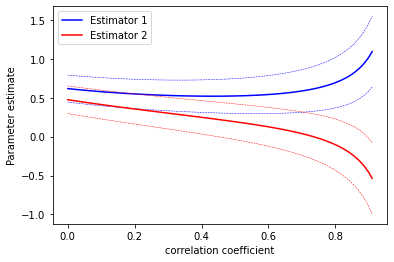

In [42]:
confidence_intervals_low = pd.DataFrame(confidence_intervals_low).add_prefix('CI_low_')[['CI_low_B1', 'CI_low_B2']]
confidence_intervals_low['r'] = correlation_level
confidence_intervals_high = pd.DataFrame(confidence_intervals_high).add_prefix('CI_high_')[['CI_high_B1', 'CI_high_B2']]
confidence_intervals_high['r'] = correlation_level
confidence_intervals = pd.merge(confidence_intervals_low, confidence_intervals_high, how='left', on='r')
parameters = pd.DataFrame(parameters)
parameters['r'] = correlation_level
parameters = pd.merge(parameters, confidence_intervals, how='left', on='r')

plt.plot(parameters['r'], parameters['B1'], label = "Estimator 1", color = "blue")
plt.plot(parameters['r'], parameters['CI_low_B1'], color = "blue", linestyle='dashed', linewidth = 0.5)
plt.plot(parameters['r'], parameters['CI_high_B1'], color = "blue", linestyle='dashed', linewidth = 0.5)

plt.plot(parameters['r'], parameters['B2'], label = "Estimator 2", color = "red")
plt.plot(parameters['r'], parameters['CI_low_B2'], color = "red", linestyle='dashed', linewidth = 0.5)
plt.plot(parameters['r'], parameters['CI_high_B2'], color = "red", linestyle='dashed', linewidth = 0.5)

plt.xlabel("correlation coefficient")
plt.ylabel("Parameter estimate")
plt.legend()


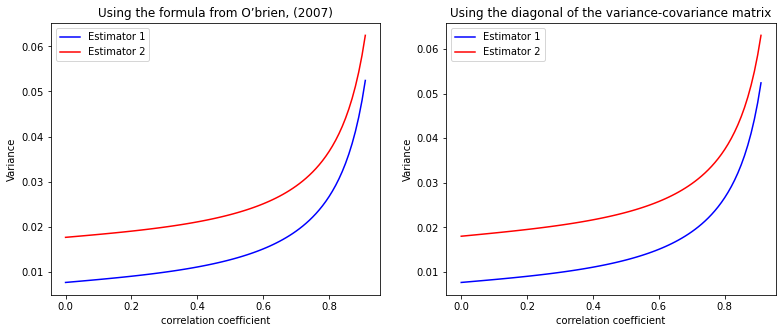

In [43]:
variance = pd.DataFrame(variance)
variance['r'] = correlation_level

variance_cov = pd.DataFrame(variance_cov)
variance_cov['r'] = correlation_level

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(13)

# Set common labels
ax1.set_xlabel('correlation coefficient')
ax1.set_ylabel('Variance')
ax2.set_xlabel('correlation coefficient')
ax2.set_ylabel('Variance')

# Set titles
ax1.set_title("Using the formula from O’brien, (2007)")
ax2.set_title("Using the diagonal of the variance-covariance matrix")

# plot graphs

ax1.plot(variance['r'], variance['B1'], label = "Estimator 1", color = "blue")
ax1.plot(variance['r'], variance['B2'] +0.01 , label = "Estimator 2", color = "red")
ax1.legend()

ax2.plot(variance_cov['r'], variance_cov['B1'], label = "Estimator 1", color = "blue")
ax2.plot(variance_cov['r'], variance_cov['B2'] +0.01 , label = "Estimator 2", color = "red")
ax2.legend()

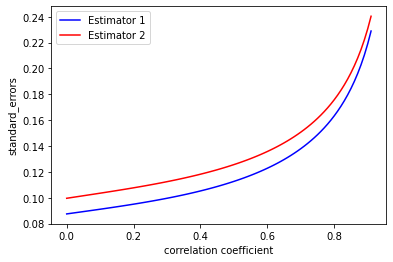

In [44]:
standard_errors = pd.DataFrame(standard_errors)
standard_errors['r'] = correlation_level
standard_errors

plt.plot(standard_errors['r'], standard_errors['B1'], label = "Estimator 1", color = "blue")
plt.plot(standard_errors['r'], standard_errors['B2'] +0.01 , label = "Estimator 2", color = "red")
plt.xlabel("correlation coefficient")
plt.ylabel("standard_errors")
plt.legend()

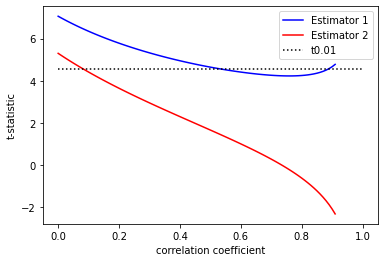

In [45]:
t_values = pd.DataFrame(t_values)
t_values['r'] = correlation_level
t_values

plt.plot(t_values['r'], t_values['B1'], label = "Estimator 1", color = "blue")
plt.plot(t_values['r'], t_values['B2'], label = "Estimator 2", color = "red")
plt.plot([0, 1], [4.541, 4.541], linestyle='dotted', color = "black", label = "t0.01")
plt.xlabel("correlation coefficient")
plt.ylabel("t-statistic")
plt.legend()


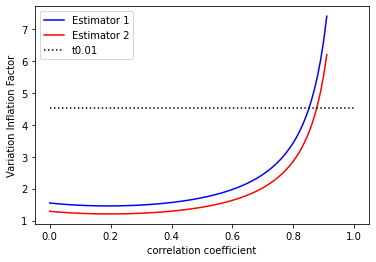

In [46]:
VIF = pd.DataFrame(VIF)
VIF['r'] = correlation_level
VIF

plt.plot(VIF['r'], VIF['B1'], label = "Estimator 1", color = "blue")
plt.plot(VIF['r'], VIF['B2'], label = "Estimator 2", color = "red")
plt.plot([0, 1], [4.541, 4.541], linestyle='dotted', color = "black", label = "t0.01")
plt.xlabel("correlation coefficient")
plt.ylabel("Variation Inflation Factor")
plt.legend()